# Black Garlic CNN Modellingh via Transfer Learning

In [2]:
import tensorflow as tf
print(tf.keras.__version__)

3.4.1


In [2]:
physical_devices = tf.config.list_physical_devices('XPU')
physical_devices

[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]

## Add functions

In [3]:
#Prep the notebook
#import necessary sources 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from sklearn.metrics import accuracy_score

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os
import zipfile

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

run_counter=0

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, name="model"): 
    # Create the confustion matrix
    global run_counter
    run_counter=run_counter+1
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with
    
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
    
    # Save the figure to the current working directory
    if savefig:
        fig.savefig(str(run_counter)+"_"+name+"_confusion_matrix.tiff",dpi=300, bbox_inches='tight')
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
  
def plot_loss_curves(history,figsize=(8, 8), model_name=""):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"_loss.tiff",dpi=300,bbox_inches='tight')
    
    # Plot accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"_accuracy.tiff",dpi=300,bbox_inches='tight')

def compare_historys(original_history, new_history, initial_epochs=5, model_name=""):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    #plt.show()
    plt.savefig(str(run_counter)+"_"+model_name+"_tuned_history.tiff",dpi=300,bbox_inches='tight')
  
def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

## Data Preparation

In [4]:

#inspect the dataset directory
walk_through_dir("black_garlic_main")

# Create training, validation and test directories
train_dir = "black_garlic_main/train/"
test_dir = "black_garlic_main/test/"
val_dir = "black_garlic_main/val/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = keras.utils.image_dataset_from_directory(directory=train_dir,
                                                      image_size=IMG_SIZE,
                                                      label_mode="categorical",
                                                      batch_size=32)
test_data = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=32,
                                                     shuffle=False)
val_data = keras.utils.image_dataset_from_directory(directory=val_dir,
                                                    image_size=IMG_SIZE,
                                                    batch_size=32,
                                                    label_mode="categorical",
                                                    shuffle=True)


There are 3 directories and 0 images in 'black_garlic_main'.
There are 3 directories and 0 images in 'black_garlic_main/train'.
There are 0 directories and 370 images in 'black_garlic_main/train/underaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/overaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/test'.
There are 0 directories and 20 images in 'black_garlic_main/test/underaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/overaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/val'.
There are 0 directories and 65 images in 'black_garlic_main/val/underaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/overaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/excellent'.
Found 1110 files belonging to 3 classes.


2024-07-06 11:33:20.920613: I tensorflow/core/common_runtime/next_pluggable_device/next_pluggable_device_factory.cc:118] Created 1 TensorFlow NextPluggableDevices. Physical device type: XPU


Found 60 files belonging to 3 classes.
Found 195 files belonging to 3 classes.


In [5]:
#Script to generate important details and figures
res = []
def generate_details(model,test_data,history,tuned=False):
    print("Evaluating...")
    loaded_loss, loaded_accuracy = model.evaluate(test_data)
    loaded_loss, loaded_accuracy
    print("done.")
    #make predictions usind the model
    print("Predicting...")
    pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
    print("done.")

    #save the evaluation results for tabulation
    res.append([model.name,round(loaded_loss*100,4),round(loaded_accuracy*100,4)])
    
    # Get the class predicitons of each label
    pred_classes = pred_probs.argmax(axis=1)
    
    # How do they look?
    pred_classes[:10]
    
    # make labels using unbatch
    y_labels = []
    for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
    y_labels[:10] # check what they look like (unshuffled)
    
    # Get accuracy score by comparing predicted classes to ground truth labels
    sklearn_accuracy = accuracy_score(y_labels, pred_classes)
    sklearn_accuracy
    
    # Does the evaluate method compare to the Scikit-Learn measured accuracy?
    import numpy as np
    print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
    
    # Get the class names
    class_names = test_data.class_names
    class_names[:10]
    
    #Genrate the confusion matrix
    make_confusion_matrix(y_true=y_labels,
                          y_pred=pred_classes,
                          classes=class_names,
                          figsize=(5, 5),
                          text_size=10,
                          norm=True,#with percentage
                          savefig=True,
                          name=model.name)
    if tuned:
        #plot hystorys
        compare_historys(original_history=history[0],
                         new_history=history[1],
                         initial_epochs=history[2],
                         model_name=model.name)
    else:
        #Plot the curves
        plot_loss_curves(history[0],figsize=(6, 3), model_name=model.name)


# Setup checkpoint path
def setup_checkpoint(model_name):
    weights_checkpoint_path = "checkpoints/"+model_name+".weights.h5"
    model_checkpoint_path = "checkpoints/"+model_name+"model.keras" 
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    weights_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_checkpoint_path,
                                                             save_weights_only=True, # set to False to save the entire model
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    # Create a ModelCheckpoint callback that saves the whole model
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    return (weights_checkpoint_callback, weights_checkpoint_path)

#results printer
def show_results(results):
    all_results = pd.DataFrame(results, columns=["Model", "Loss", "Accuracy"])
    all_results.to_csv('RESULTS.csv')
    return all_results

# Model 1 EfficientNetB0

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
              
model_1.name="Model_1_EfficientNetB0"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1 = model_1.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10


2024-07-05 23:04:52.738755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4532 - loss: 1.0673
Epoch 1: val_loss improved from inf to 0.68212, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.4566 - loss: 1.0633 - val_accuracy: 0.7744 - val_loss: 0.6821
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8089 - loss: 0.6597
Epoch 2: val_loss improved from 0.68212 to 0.48650, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.8097 - loss: 0.6580 - val_accuracy: 0.8667 - val_loss: 0.4865
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8942 - loss: 0.4814
Epoch 3: val_loss improved from 0.48650 to 0.38664, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.8942 - loss: 0.4807 - val_accuracy: 0.9128 - val_loss: 0.3866
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy:

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9785 - loss: 0.1586  
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -4.371007278347605e-08


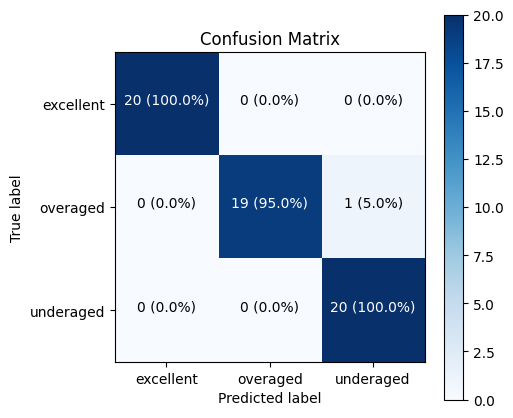

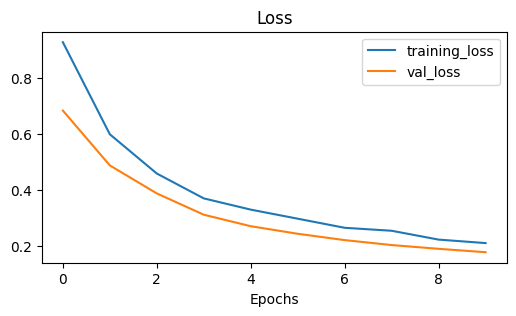

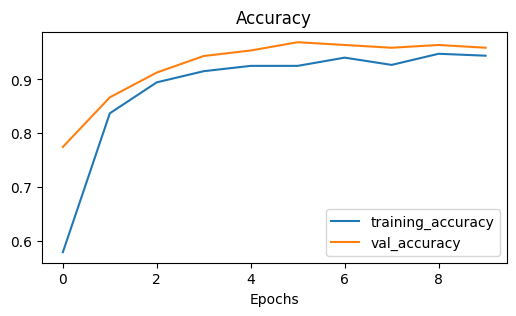

In [7]:
#Generate needed details
generate_details(model_1,test_data,[history1])

# Model 1 EfficientNetB0 with fine-tuning

In [8]:
model_1.load_weights(checkpoint_path)
model_1.layers[1].trainable = False

for layer in model_1.layers[1].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
model_1.name="Model_1_EfficientNetB0_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1_tuned = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history1.epoch[-1], 
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9262 - loss: 0.2456
Epoch 10: val_loss improved from inf to 0.12539, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.9266 - loss: 0.2445 - val_accuracy: 0.9641 - val_loss: 0.1254
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9624 - loss: 0.1262
Epoch 11: val_loss improved from 0.12539 to 0.08625, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9624 - loss: 0.1260 - val_accuracy: 0.9692 - val_loss: 0.0863
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9681 - loss: 0.0950
Epoch 12: val_loss improved from 0.08625 to 0.07703, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9681 - loss: 0.0951 - val_accuracy: 0.9641 - val_loss: 0.

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0355
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -5.960464477539063e-08


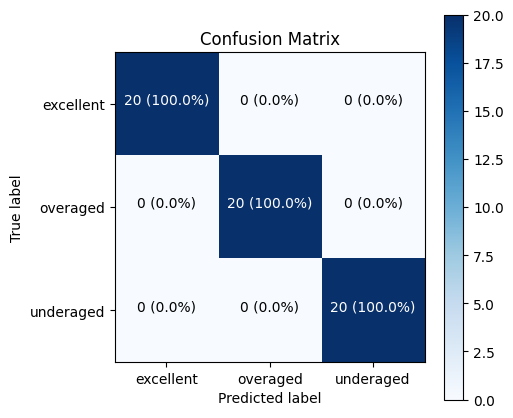

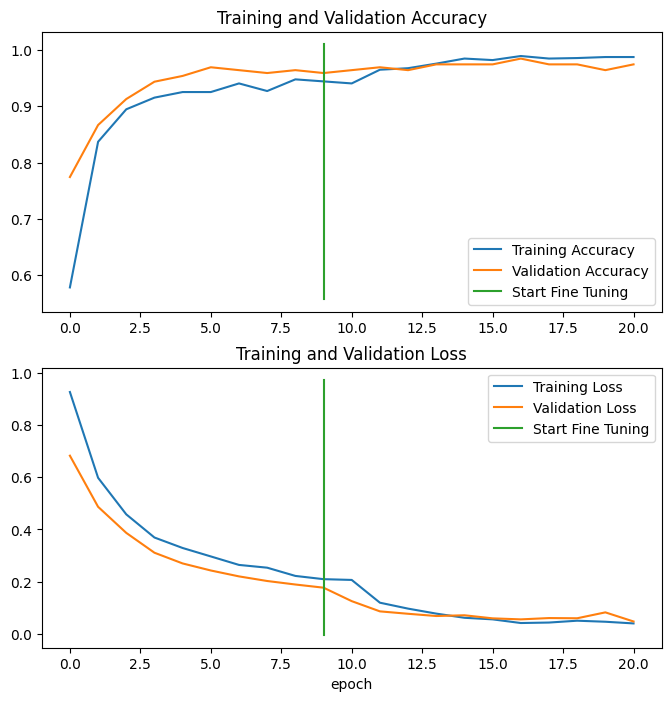

In [9]:
#Generate needed details
generate_details(model_1,test_data,[history1,history1_tuned,10],True)

# Model 2 EfficientNetB0 with augmentation

In [10]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_2.name="Model_2_EfficientNetB0_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

history2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4497 - loss: 1.0512
Epoch 1: val_loss improved from inf to 0.78435, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.4531 - loss: 1.0480 - val_accuracy: 0.7487 - val_loss: 0.7843
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7266 - loss: 0.7374
Epoch 2: val_loss improved from 0.78435 to 0.61266, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.7280 - loss: 0.7354 - val_accuracy: 0.8000 - val_loss: 0.6127
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8357 - loss: 0.5646
Epoch 3: val_loss improved from 0.61266 to 0.49135, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.8361 - loss: 0.5640 - val_accuracy: 0.8359 - val_loss: 0.491

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9562 - loss: 0.2188
done.
Predicting...
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f859d18a940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -7.152557368605983e-08


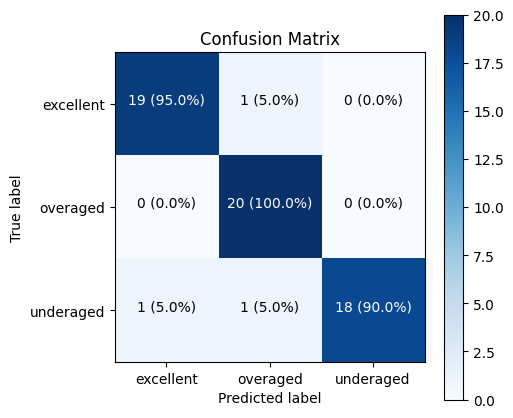

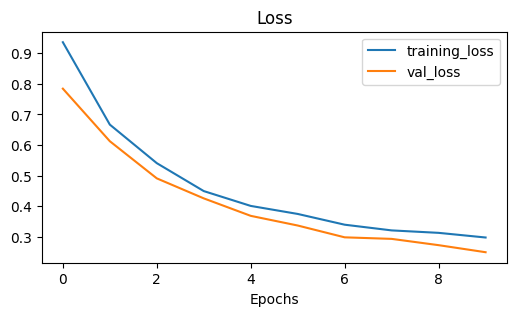

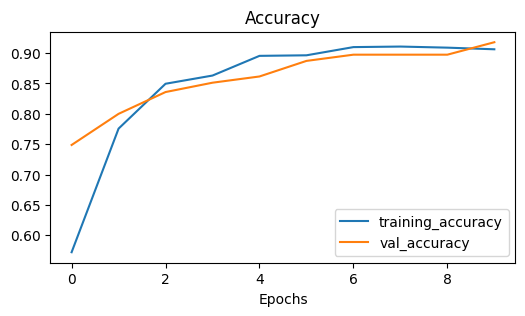

In [11]:
#Generate needed details
generate_details(model_2,test_data,[history2])

# Model 2 EfficientNetB0 with augmentation and fine-tuning

In [12]:
model_2.load_weights(checkpoint_path)
model_2.layers[2].trainable = False

for layer in model_2.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_2.name = "Model_2_EfficientNetB0_with_augmentation_and_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history2_tuned = model_2.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history2.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8465 - loss: 0.4022
Epoch 10: val_loss improved from inf to 0.17668, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 265ms/step - accuracy: 0.8481 - loss: 0.3990 - val_accuracy: 0.9333 - val_loss: 0.1767
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9596 - loss: 0.1544
Epoch 11: val_loss improved from 0.17668 to 0.14167, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9597 - loss: 0.1541 - val_accuracy: 0.9436 - val_loss: 0.1417
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9606 - loss: 0.1167
Epoch 12: val_loss improved from 0.14167 to 0.13997, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9607 -

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9569 - loss: 0.0543
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -8.74201456779744e-08


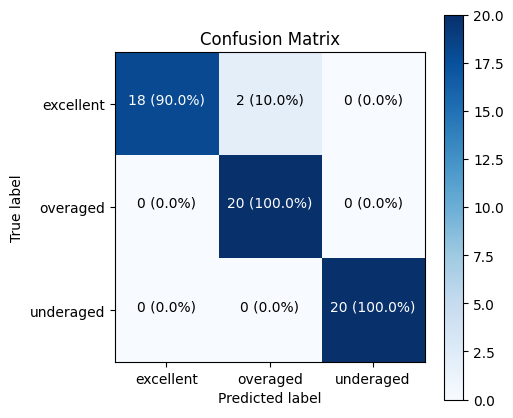

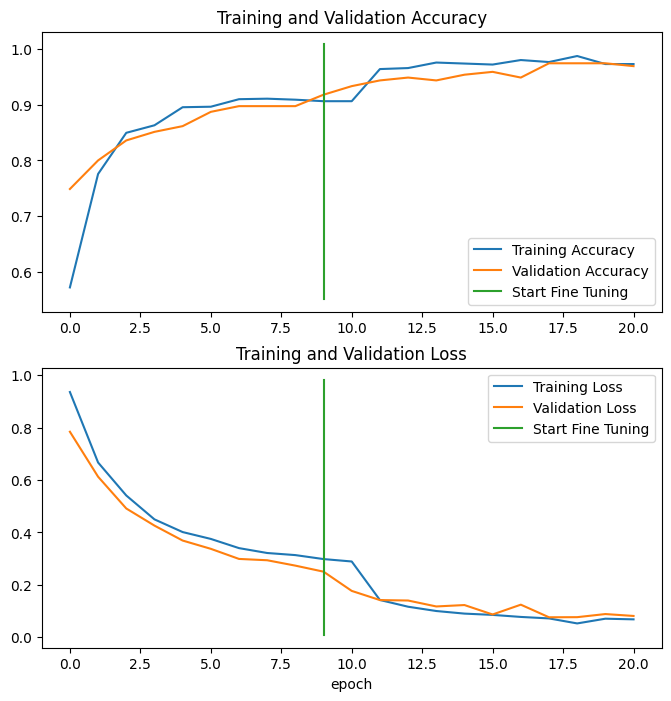

In [13]:
#Generate needed details
generate_details(model_2,test_data,[history2,history2_tuned,10],True)

# Model 3 ResNet50v2

In [14]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255,name="rescaler")(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

history3 = model_3.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4031 - loss: 1.5533
Epoch 1: val_loss improved from inf to 0.79096, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.4044 - loss: 1.5472 - val_accuracy: 0.6769 - val_loss: 0.7910
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6395 - loss: 0.8322
Epoch 2: val_loss improved from 0.79096 to 0.52883, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6407 - loss: 0.8294 - val_accuracy: 0.7949 - val_loss: 0.5288
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7674 - loss: 0.5844
Epoch 3: val_loss improved from 0.52883 to 0.41212, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7680 - loss: 0.5831 - val_accuracy: 0.8769 - val_loss: 0.4121
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - accuracy: 0.9340 - loss: 0.2078
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 971ms/step
done.
Close? True | Difference: -3.973642981325298e-08


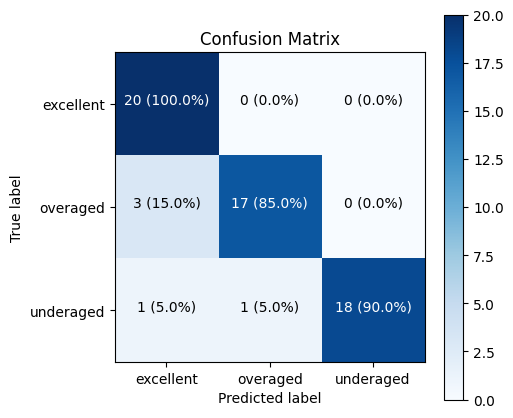

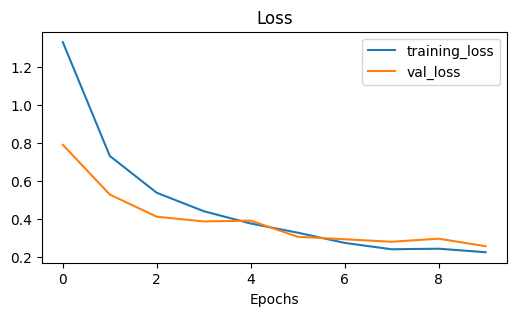

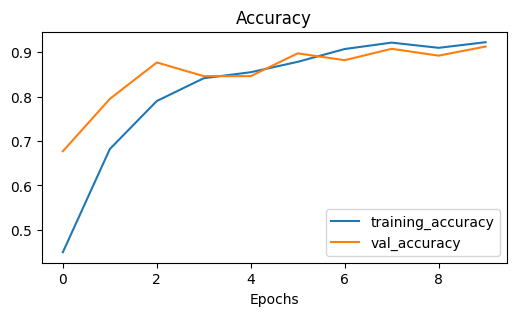

In [15]:
#Generate needed details
generate_details(model_3,test_data,[history3])

# Model 3 ResNet50v2 with fine-tuning

In [16]:
model_3.load_weights(checkpoint_path)
model_3.layers[2].trainable = False

for layer in model_3.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history3_tuned = model_3.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history3.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8685 - loss: 0.3360
Epoch 10: val_loss improved from inf to 0.18740, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.8696 - loss: 0.3336 - val_accuracy: 0.9282 - val_loss: 0.1874
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9842 - loss: 0.0638
Epoch 11: val_loss improved from 0.18740 to 0.11372, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9842 - loss: 0.0637 - val_accuracy: 0.9692 - val_loss: 0.1137
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9948 - loss: 0.0416
Epoch 12: val_loss improved from 0.11372 to 0.08775, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9948 - loss: 0.0417 - val_accuracy: 0.9744 - val_loss: 0.0877
Epoch 1

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0105
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 946ms/step
done.
Close? True | Difference: -5.960464477539063e-08


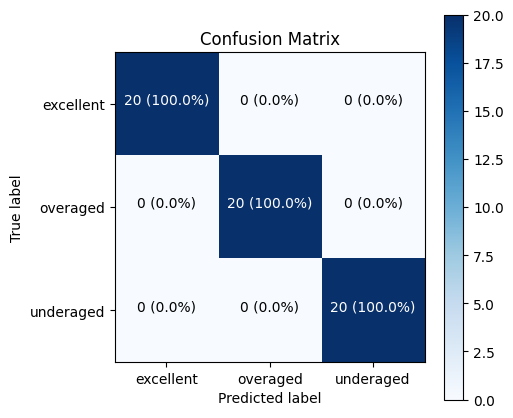

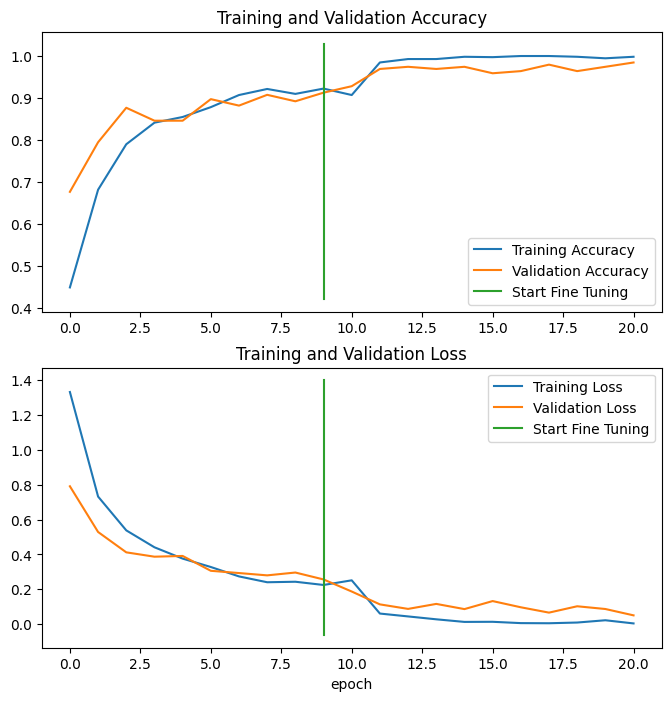

In [17]:
#Generate needed details
generate_details(model_3,test_data,[history3,history3_tuned,10],True)

# Model 4 ResNet50v2 with augmentation

In [18]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")


input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_4 = keras.Model(inputs, outputs)

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

history4 = model_4.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3962 - loss: 1.3278
Epoch 1: val_loss improved from inf to 0.70469, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.3984 - loss: 1.3229 - val_accuracy: 0.7231 - val_loss: 0.7047
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6577 - loss: 0.7879
Epoch 2: val_loss improved from 0.70469 to 0.52812, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.6587 - loss: 0.7862 - val_accuracy: 0.7949 - val_loss: 0.5281
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7423 - loss: 0.6159
Epoch 3: val_loss improved from 0.52812 to 0.44584, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.7426 - loss: 0.6152 - val_accuracy: 0.8205 - val_loss: 0.4458
Epoch 4/10

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9444 - loss: 0.2310
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 963ms/step
done.
Close? True | Difference: -3.973642981325298e-08


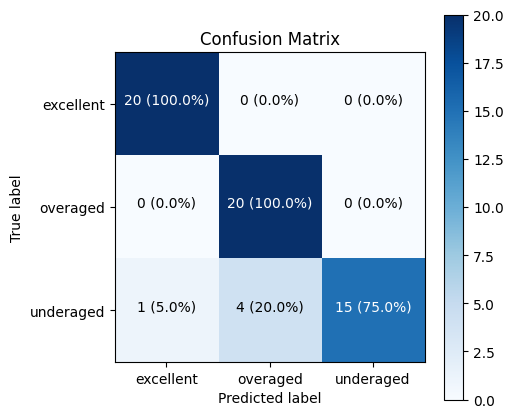

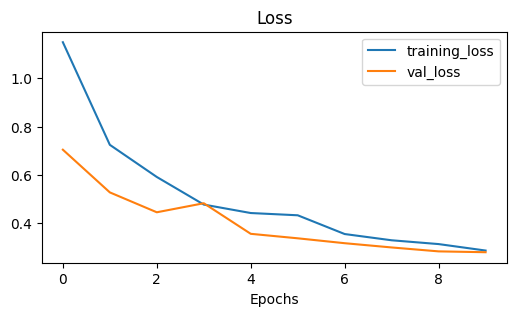

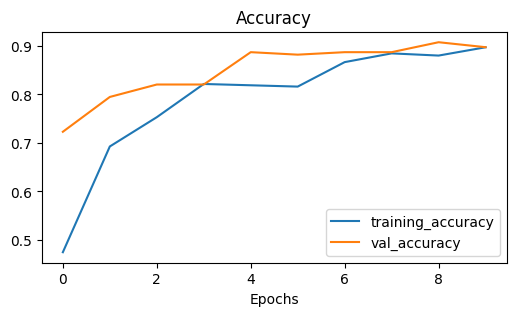

In [19]:
#Generate needed details
generate_details(model_4,test_data,[history4])

# Model 4 ResNet50v2 with augmentation with fine-tuning

In [20]:
model_4.load_weights(checkpoint_path)
model_4.layers[3].trainable = False

for layer in model_4.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history4_tuned = model_4.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history4.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8590 - loss: 0.3585
Epoch 10: val_loss improved from inf to 0.25006, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.8593 - loss: 0.3578 - val_accuracy: 0.9077 - val_loss: 0.2501
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9078 - loss: 0.2383
Epoch 11: val_loss improved from 0.25006 to 0.24327, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.9078 - loss: 0.2381 - val_accuracy: 0.8974 - val_loss: 0.2433
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9484 - loss: 0.1561
Epoch 12: val_loss improved from 0.24327 to 0.16414, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9485 - loss: 0.

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9889 - loss: 0.1128
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 974ms/step
done.
Close? True | Difference: -4.371007278347605e-08


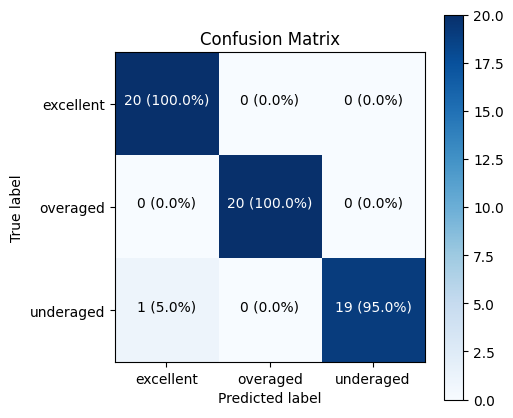

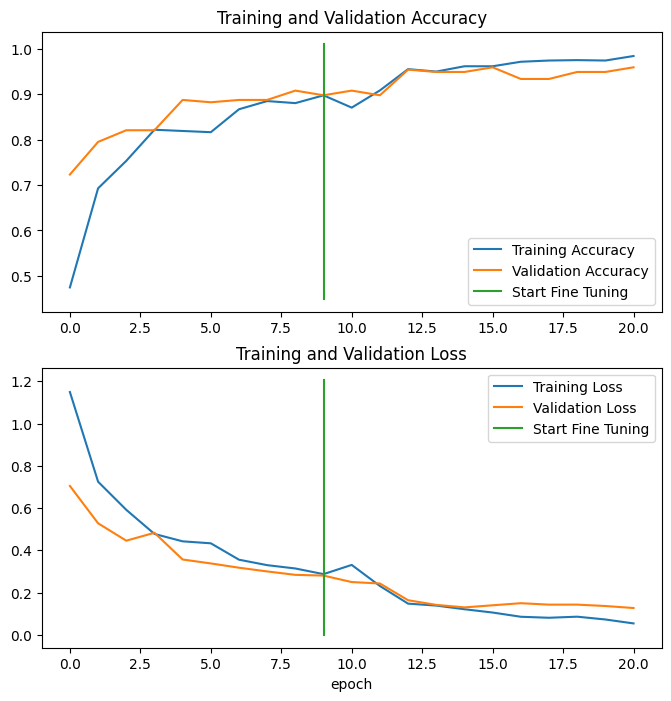

In [21]:
#Generate needed details
generate_details(model_4,test_data,[history4,history4_tuned,10],True)

# Model 5 VGG16

In [7]:
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(x)
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_5 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

#history5 = model_5.fit(train_data,
#                       epochs=10,
#                       validation_data=val_data,
#                       callbacks=[checkpoint_callback]
#                      )

In [8]:
model_5.summary()

Model: "Model_5_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.6083 - loss: 0.9681
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
done.
Close? True | Difference: -3.5762786843029915e-08


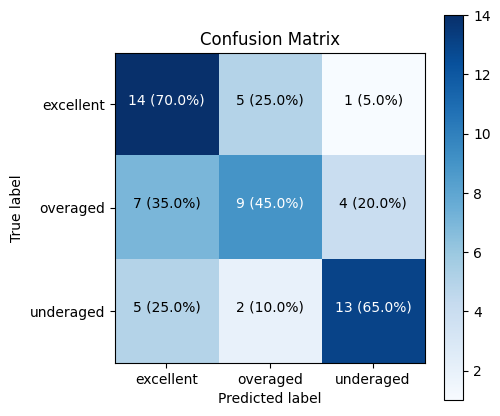

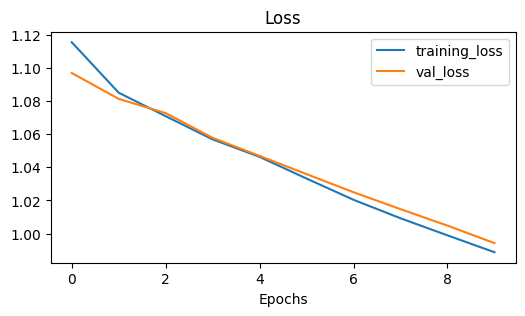

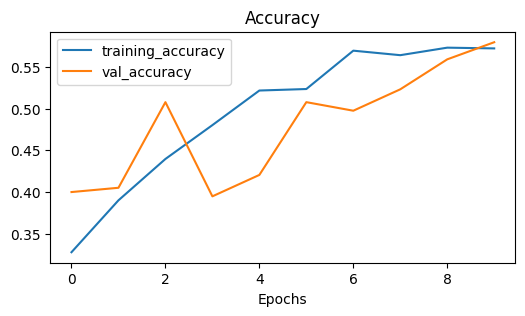

In [23]:
#Generate needed details
generate_details(model_5,test_data,[history5])

# Model 5 VGG16 with fine-tuning

In [6]:
model_5.load_weights(checkpoint_path)
model_5.layers[2].trainable = False

for layer in model_5.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history5_tuned = model_5.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history5.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

NameError: name 'model_5' is not defined

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9778 - loss: 0.0648    
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
done.
Close? True | Difference: -8.74201456779744e-08


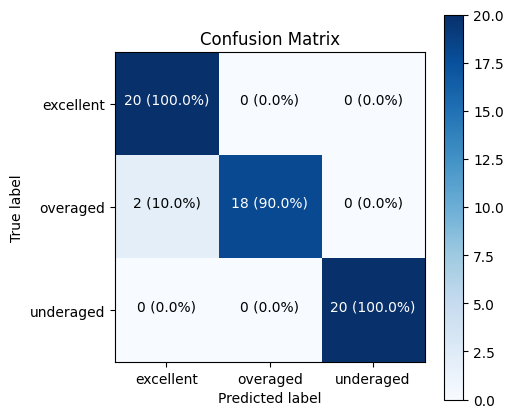

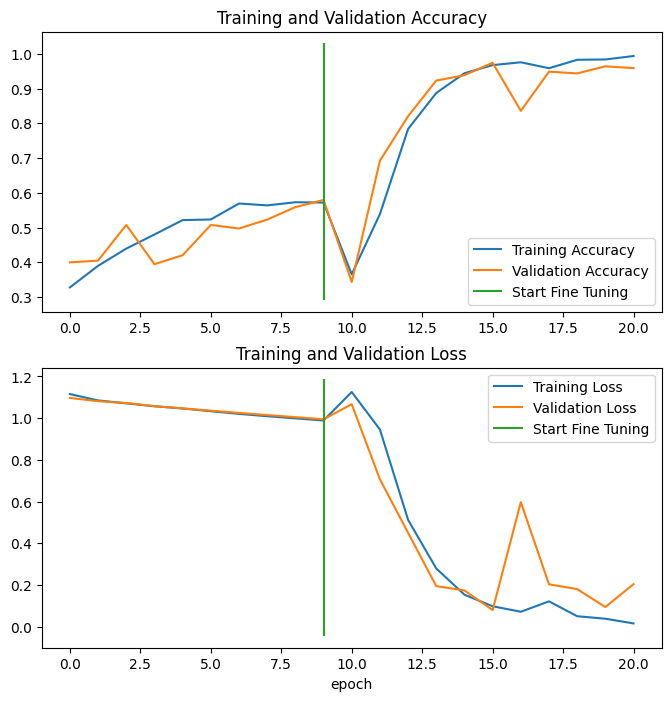

In [25]:
#Generate needed details
generate_details(model_5,test_data,[history5,history5_tuned,10],True)

# Model 6 VGG16 with augmentation

In [26]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_6 = keras.Model(inputs, outputs)

model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_6.name = "Model_6_VGG16_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

history6 = model_6.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2839 - loss: 1.1354
Epoch 1: val_loss improved from inf to 1.09963, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.2845 - loss: 1.1348 - val_accuracy: 0.3692 - val_loss: 1.0996
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3395 - loss: 1.0952
Epoch 2: val_loss improved from 1.09963 to 1.09612, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.3403 - loss: 1.0951 - val_accuracy: 0.3436 - val_loss: 1.0961
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3708 - loss: 1.0900
Epoch 3: val_loss improved from 1.09612 to 1.07760, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.3713 - loss: 1.0898 - val_accuracy: 0.3897 - val_loss: 1.0776
Epoch 4/10
35/35 ━━━━━━━━━

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4903 - loss: 1.0186
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
done.
Close? True | Difference: -1.5894571991914574e-08


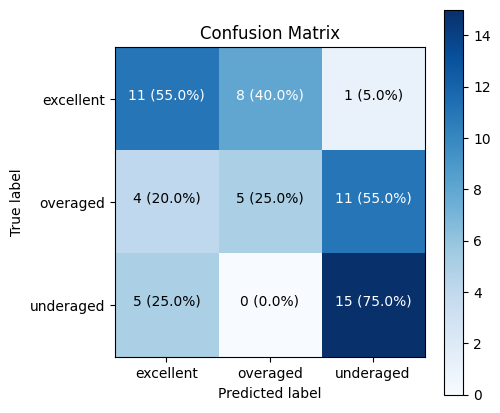

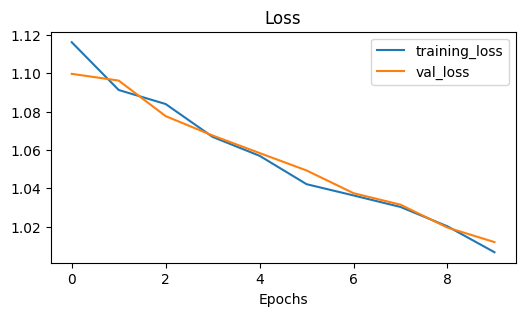

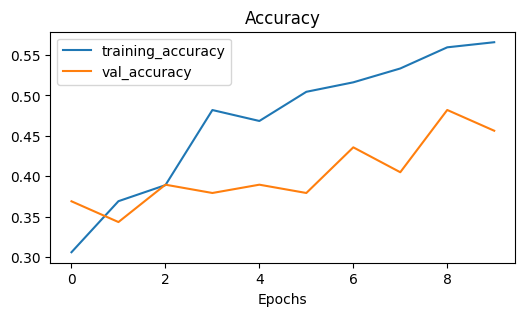

In [27]:
#Generate needed details
generate_details(model_6,test_data,[history6])

# Model 6 VGG16 with augmentation and fine-tuning

In [28]:
model_6.load_weights(checkpoint_path)
model_6.layers[3].trainable = False

for layer in model_6.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate
              metrics=["accuracy"])

model_6.name = "Model_6_VGG16_with_augmentation_and_fine-tuningn"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history6_tuned = model_6.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history6.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4982 - loss: 1.0116
Epoch 10: val_loss improved from inf to 0.61019, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.5012 - loss: 1.0066 - val_accuracy: 0.7692 - val_loss: 0.6102
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8490 - loss: 0.3894
Epoch 11: val_loss improved from 0.61019 to 0.14143, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.8495 - loss: 0.3885 - val_accuracy: 0.9487 - val_loss: 0.1414
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9216 - loss: 0.1979
Epoch 12: val_loss did not improve from 0.14143
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9217 - loss: 0.1978 - val_accuracy: 0.9436 - val_loss: 0.1678
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accura

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0150
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
done.
Close? True | Difference: -5.960464477539063e-08


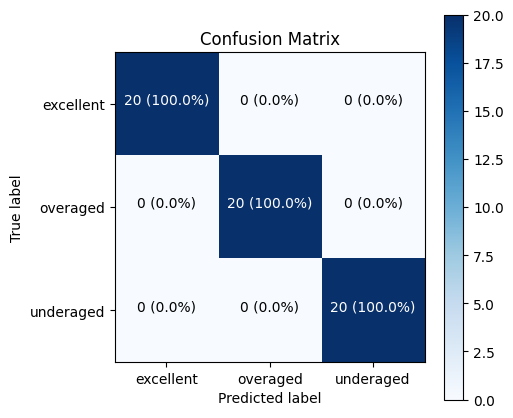

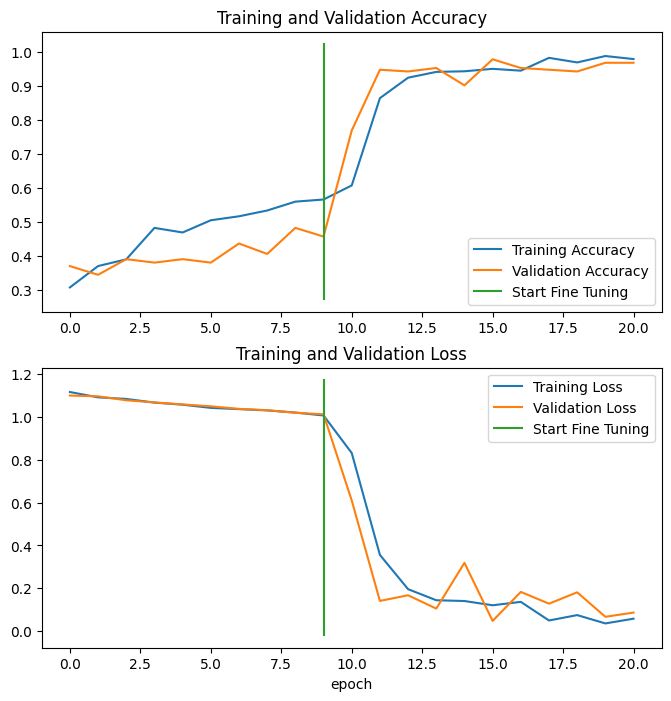

In [29]:
#Generate needed details
generate_details(model_6,test_data,[history6,history6_tuned,10],True)

# RESULT SUMMARY

In [30]:
show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,17.0601,98.3333
1,Model_1_EfficientNetB0_with_fine-tuning,3.1226,100.0000
2,Model_2_EfficientNetB0_with_augmentation,23.8279,95.0000
3,Model_2_EfficientNetB0_with_augmentation_and_f...,4.3502,96.6667
4,Model_3_ResNet50v2,23.0407,91.6667
5,Model_3_ResNet50v2_with_fine-tuning,1.0158,100.0000
6,Model_4_ResNet50v2_with_augmentation,28.7889,91.6667
7,Model_4_ResNet50v2_with_augmentation_with_fine...,14.4288,98.3333
8,Model_5_VGG16,97.3703,60.0000
9,Model_5_VGG16_with_fine-tuning,9.7115,96.6667
